In [1]:
# basic imports
import random
import numpy as np
import os
import sys

# DL library imports
import torch
import segmentation_models_pytorch as smp
# import torch.nn as nn
# import torch.nn.functional as F

# libraries for loading image, plotting 
# import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
model_dir = '/home/j/j_sten07/palma_models'
# model_name = 'UNet_baseline_last.pt'
model_name = 'segformer_30epochs_jaccardloss_0.0003lr_best.pt'
# model_name = 'unet_50epochs_jaccardloss_0.0003lr_8batches_last.pt'
data_path = '/home/j/j_sten07/thesis_test/data/Potsdam/patches/500px'

In [30]:
# load dataset and create data loader
sys.path.append('..')
from utils import make_loader, load_datasets
train_dataset, val_dataset, test_dataset = load_datasets(data_path)
train_loader, val_loader, test_loader = make_loader(train_dataset, val_dataset, test_dataset)

In [31]:
from utils import IoU                  # metric class
from utils import evaluate_model

import sys
# from models import UNet, UNetEncoder, UNetDecoder

In [32]:
# load model
# MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_best.pt')
MODEL_PATH = os.path.join(model_dir, model_name)
checkpoint = torch.load(MODEL_PATH)
model = checkpoint['model']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)
NUM_CLASSES = 6
# model.to(device)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

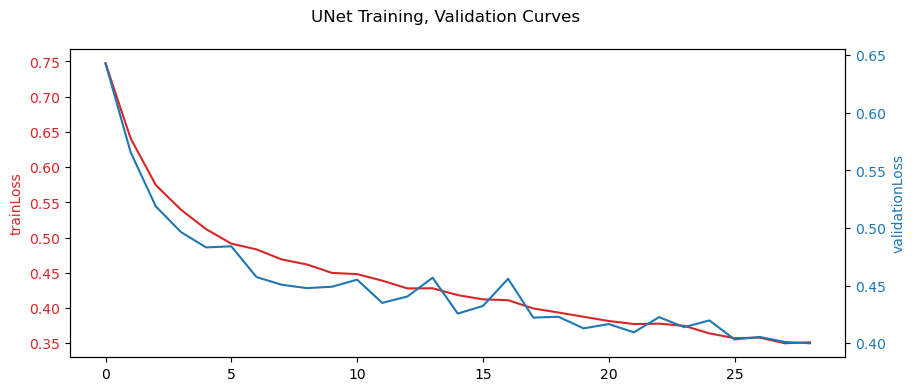

In [33]:
from utils import plot_training_results

results_df = pd.DataFrame(checkpoint['results'])
plot_training_results(results_df, 'UNet')

In [34]:
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


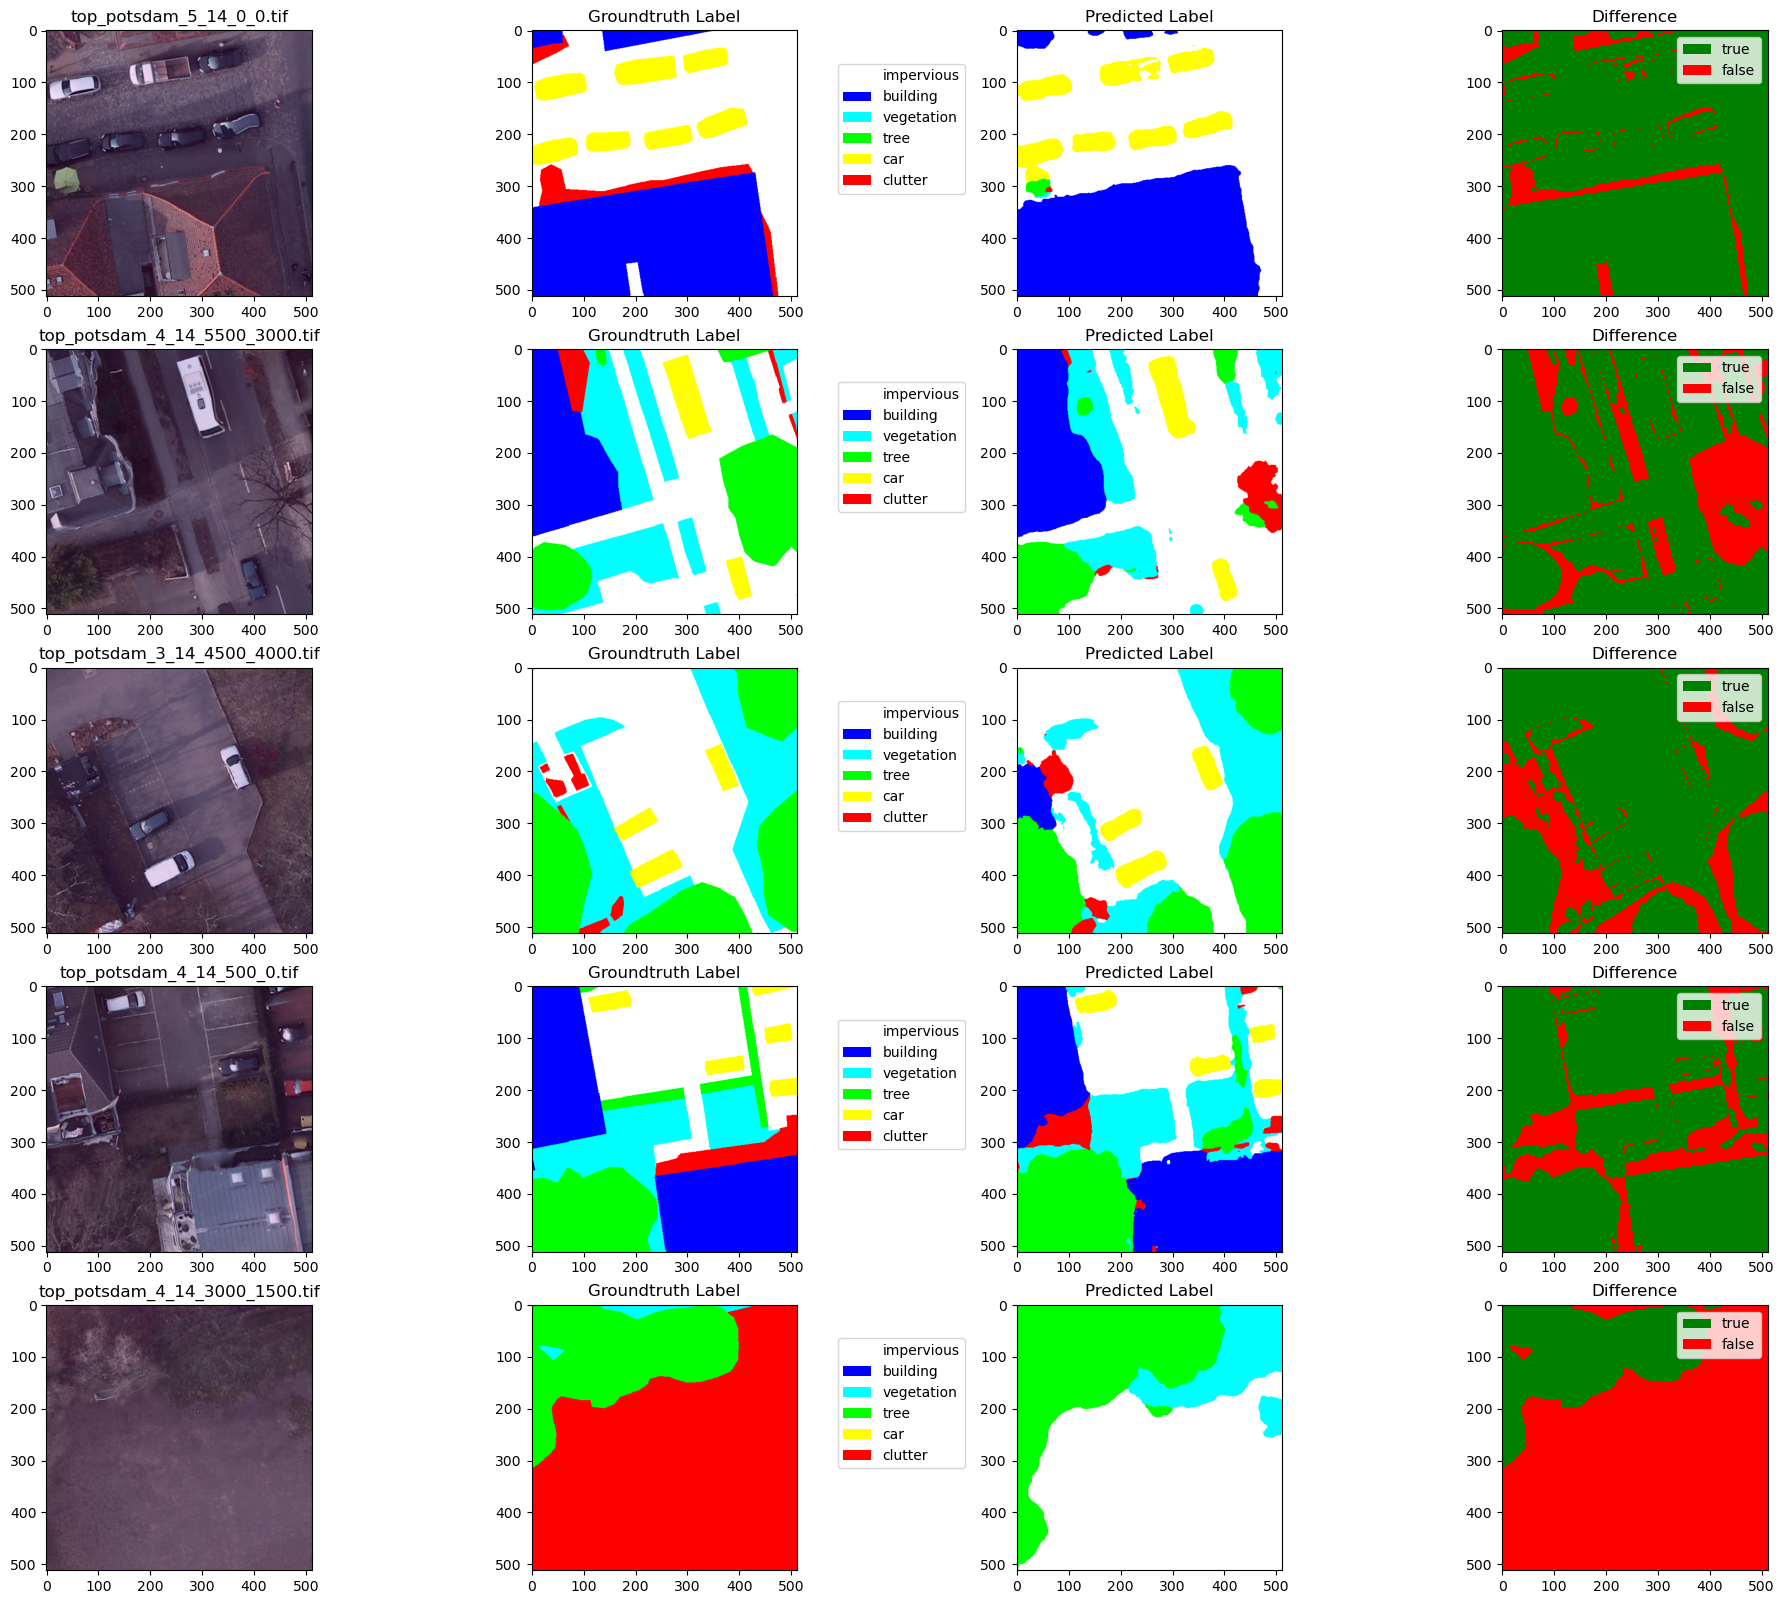

In [35]:
# plot test predictions
from utils import visualize_predictions, train_id_to_color, drivables

num_test_samples = 5
_, axes = plt.subplots(num_test_samples, 4, figsize=(4*6, num_test_samples * 4))
visualize_predictions(model, test_dataset, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

In [36]:
# evaluate model performance on test dataset
_, test_metric = evaluate_model(model, test_loader, criterion, IoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} metrices in test set")

100%|██████████| 360/360 [01:48<00:00,  3.31it/s]


Model has {'accuracy': 0.8021400822533502, 'miou': 0.6243050470642394, 'classwise_iou': array([0.71680488, 0.83287378, 0.63126162, 0.61999104, 0.75753223,
       0.18736673]), 'classwise_f1': array([0.83504525, 0.90881739, 0.77395509, 0.76542527, 0.86204078,
       0.31560044]), 'f1_mean': 0.7434807045208468, 'matrix': array([[4.3205572e+07, 1.3408780e+06, 2.0470530e+06, 1.1629270e+06,
        2.0983500e+05, 4.3320500e+05],
       [2.1486480e+06, 3.5836016e+07, 4.0395600e+05, 1.9510700e+05,
        3.0270000e+04, 8.3119600e+05],
       [3.5214410e+06, 6.5133000e+05, 3.7118908e+07, 5.8420090e+06,
        1.6711000e+04, 1.0490600e+06],
       [2.5030850e+06, 3.2198700e+05, 7.0480060e+06, 3.0046460e+07,
        1.7033800e+05, 4.1522300e+05],
       [2.5273300e+05, 4.7305000e+04, 2.1446000e+04, 5.0307000e+04,
        3.0339340e+06, 7.2306000e+04],
       [3.4498430e+06, 1.2202540e+06, 1.0812280e+06, 7.0728400e+05,
        9.9838000e+04, 2.1579810e+06]])} metrices in test set


In [38]:
# 1. Run model on test dataset
# 2. Visualize matrix

In [39]:
# get matrix from results
# results = results_df.metrices[len(results_df)-1] 
results = test_metric
matrix = results['matrix']
# calculate recall and respective values for wrong segmentations
matrix_per = matrix / matrix.sum(axis = 1)[np.newaxis].T # transpose sum to apply divison to rows
recall = np.diag(matrix_per)
# other metrices
precision = np.diag(matrix / matrix.sum(axis = 0))
f1 = 2*precision*recall / (precision+recall)

In [40]:
# classes as captions for table
CLASSES = ['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']

In [41]:
# make df and add column names and ids
df = pd.DataFrame(matrix_per)
df.columns = [s + '_pred' for s in CLASSES]
df.index = [s + '_tr' for s in CLASSES]
# add metrices
df.loc['Precision'] = precision
df.loc['Recall'] = recall
df.loc['f1'] = f1
df.loc['IoU'] = results['classwise_iou']

In [46]:
print('Metrices')
print(f'Accuracy: {results["accuracy"]}, MeanIoU: {results["miou"]},f1 score mean: {results["f1_mean"]}')
print('"row predicted as column"')
df

Metrices
Accuracy: 0.8021400822533502, MeanIoU: 0.6243050470642394,f1 score: 0.7434807045208468
"row predicted as column"


,impervious_pred,building_pred,vegetation_pred,tree_pred,car_pred,clutter_pred
impervious_tr,0.892687,0.027704,0.042295,0.024028,0.004335,0.008951
building_tr,0.054472,0.908501,0.010241,0.004946,0.000767,0.021072
vegetation_tr,0.073060,0.013513,0.770110,0.121205,0.000347,0.021765
tree_tr,0.061797,0.007949,0.174003,0.741795,0.004205,0.010251
car_tr,0.072666,0.013601,0.006166,0.014464,0.872314,0.020789
clutter_tr,0.395786,0.139995,0.124045,0.081144,0.011454,0.247576
Precision,0.784396,0.909134,0.777838,0.790611,0.852007,0.435167
Recall,0.892687,0.908501,0.770110,0.741795,0.872314,0.247576
f1,0.835045,0.908817,0.773955,0.765425,0.862041,0.315600
IoU,0.716805,0.832874,0.631262,0.619991,0.757532,0.187367
